In [4]:
import os
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [6]:
# DEFINE CONSTANTS

FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [7]:
# JOIN DIRECTORYS

train_dir = os.path.join('','train_less_data/')
no_of_train_data = len(os.listdir(train_dir))

print('no of train data: {}'.format(no_of_train_data))

no of train data: 1002


In [8]:
# CREAT CSV FILES

categories = list()
filenames = os.listdir(train_dir)
for filename in filenames:
    name = filename.split('.')[0]
    if name=='dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [9]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.101.jpg,0


In [10]:
df.tail()

,filename,category
997,dog.95.jpg,1
998,dog.96.jpg,1
999,dog.97.jpg,1
1000,dog.98.jpg,1
1001,dog.99.jpg,1


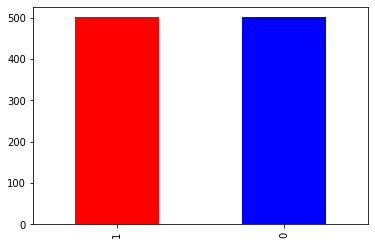

In [11]:
# PLOT VALUE_COUNT GRAPH

df['category'].value_counts().plot.bar(color=['r','b'])

In [12]:
# CREATE MODEL ARCHITECTURE

model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
          
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

W1022 09:59:23.986977  6824 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [13]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [14]:
callbacks = [earlystop, learning_rate_reduction]

In [15]:
df['category'] = df['category'].replace({0:'cat', 1:'dog'})

In [16]:
df.head()

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.101.jpg,cat


In [17]:
train_df, validation_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

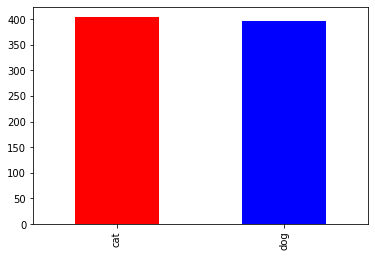

In [18]:
train_df['category'].value_counts().plot.bar(color=['r', 'b'])

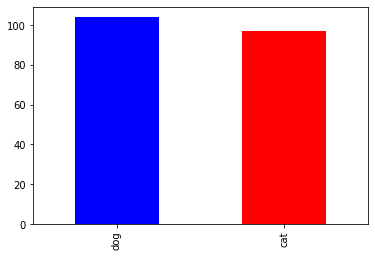

In [19]:
validation_df['category'].value_counts().plot.bar(color=['b', 'r'])

In [20]:
total_train = train_df.shape[0]
total_validate = validation_df.shape[0]
batch_size = 64

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    directory='train/', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 801 validated image filenames belonging to 2 classes.


In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    directory='train_less_data/', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 201 validated image filenames belonging to 2 classes.


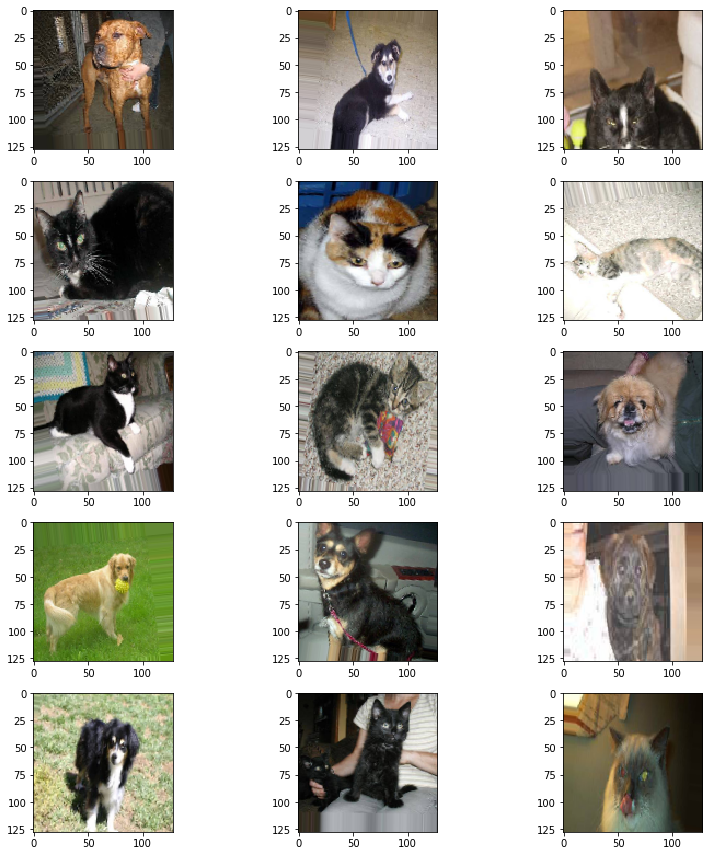

In [23]:
shape = list()
plt.figure(figsize=(12,12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for x_batch, _ in train_generator:
        img = x_batch[0]
        shape.append(img.shape)
        plt.imshow(img)
        break
plt.tight_layout()
plt.show()

In [24]:
# FIT MODEL

# epochs=3 if FAST_RUN else 10
# history = model.fit_generator(
#     train_generator, 
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=total_validate//batch_size,
#     steps_per_epoch=total_train//batch_size,
#     callbacks=callbacks
# )

In [25]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# model.save_weights('model.h5')

In [28]:
json_model = open('model.json', 'r')
loaded_model_json = json_model.read()
json_model.close()

loaded_model = model_from_json(loaded_model_json)
loaded_weights = loaded_model.load_weights('model.h5')

In [30]:
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

{'_self_setattr_tracking': True,
 '_name': 'sequential',
 '_activity_regularizer': None,
 '_trainable': True,
 '_dynamic': False,
 '_is_compiled': True,
 '_expects_training_arg': True,
 '_layers': [<tensorflow.python.keras.engine.input_layer.InputLayer at 0x13e7e710>,
 '_compute_output_and_mask_jointly': True,
 'supports_masking': False,
 'optimizer': <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop at 0x3e06b358>,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_losses': [],
 '_eager_losses': [],
 '_callable_losses': [],
 '_metrics': [],
 '_metrics_tensors': {},
 '_scope': None,
 '_reuse': None,
 '_graph': <tensorflow.python.framework.ops.Graph at 0x7a5ff60>,
 '_dtype': None,
 '_outbound_nodes': [],
 '_inbound_nodes': [<tensorflow.python.keras.engine.base_layer.Node at 0x13f84390>],
 '_trackable_saver': <tensorflow.python.training.tracking.util.TrackableSaver at 0x12bb9208>,
 '_mixed_precision_policy': <tensorflow.python.keras.mixed_precision.experime

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [32]:
test_filenames = os.listdir('test_less_data/')
test_df = pd.DataFrame(
{
    'filename': test_filenames
})

In [33]:
no_samples = test_df.shape[0]
print(no_samples)

1000


In [34]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    directory='test1/',
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 1000 validated image filenames.


In [35]:
# predict = model.predict_generator(test_generator, steps=np.ceil(no_samples/batch_size))
predict = loaded_model.predict_generator(test_generator, steps=np.ceil(no_samples/batch_size))

In [36]:
print(predict)

[[5.4254229e-03 9.9457461e-01]
 [9.9948102e-01 5.1895255e-04]
 [3.4374407e-01 6.5625590e-01]
 ...
 [7.0019946e-03 9.9299800e-01]
 [9.6200703e-05 9.9990380e-01]
 [9.9941003e-01 5.8998010e-04]]


In [37]:
test_df['category'] = np.argmax(predict, axis=-1)

In [38]:
test_df

,filename,category
0,1.jpg,1
1,10.jpg,0
2,100.jpg,1
3,1000.jpg,1
4,101.jpg,0
...,...,...
995,995.jpg,0
996,996.jpg,0
997,997.jpg,1
998,998.jpg,1


In [39]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())

In [40]:
label_map

{0: 'cat', 1: 'dog'}

In [41]:
test_df['category'] = test_df['category'].replace(label_map)

In [42]:
test_df

,filename,category
0,1.jpg,dog
1,10.jpg,cat
2,100.jpg,dog
3,1000.jpg,dog
4,101.jpg,cat
...,...,...
995,995.jpg,cat
996,996.jpg,cat
997,997.jpg,dog
998,998.jpg,dog


In [43]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

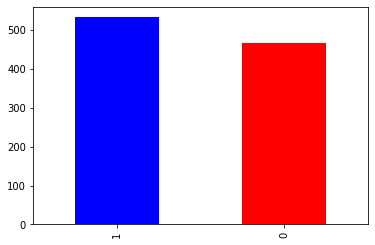

In [45]:
test_df['category'].value_counts().plot.bar(color=['b', 'r'])

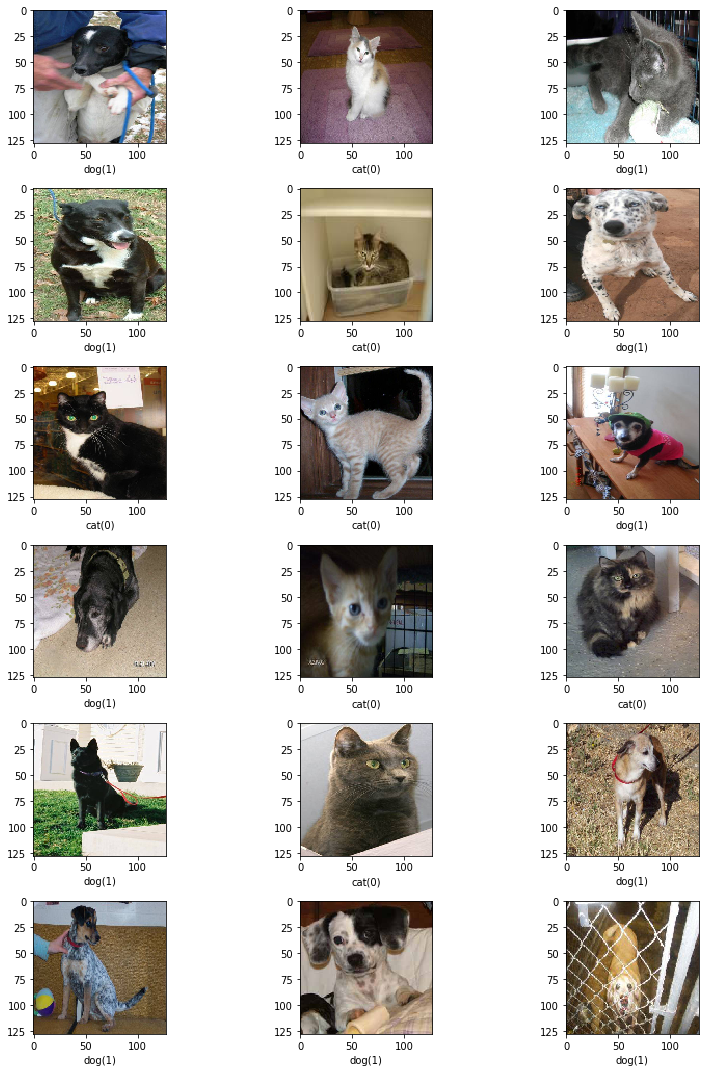

In [46]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 15))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test_less_data/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    if category == 1:
        name = 'dog'
    else:
        name = 'cat'
    plt.xlabel(name + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()